In [38]:
import os
import json
import pandas as pd

In [39]:
# === CONFIGURATION ===
GRAPH_DIR = "taxonomy_graphs_json"  
all_graph_files = [f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")]

### How often does the true class share the same family as the top-1 class

In [40]:
def extract_family_links(graph_data):
    """Return a dict mapping species id → family id using the graph links."""
    nodes = {node["id"]: node for node in graph_data["nodes"]}
    species_to_family = {}

    # First, create genus-to-family map
    genus_to_family = {}
    for link in graph_data["links"]:
        source = link["source"]
        target = link["target"]
        if nodes[source]["type"] == "family" and nodes[target]["type"] == "genus":
            genus_to_family[target] = source

    # Now build species-to-family
    for link in graph_data["links"]:
        source = link["source"]
        target = link["target"]
        if nodes[source]["type"] == "genus" and nodes[target]["type"] == "species":
            genus = source
            family = genus_to_family.get(genus)
            if family:
                species_to_family[target] = family

    return species_to_family

In [41]:
results = []

for fname in sorted(all_graph_files):
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        graph = json.load(f)

    nodes = graph["nodes"]
    top1_species = None
    true_species = None

    for node in nodes:
        if node["type"] == "species":
            if node.get("is_top1", False):
                top1_species = node["id"]
            if node.get("is_true", False):
                true_species = node["id"]

    species_to_family = extract_family_links(graph)
    top1_family = species_to_family.get(top1_species)
    true_family = species_to_family.get(true_species)

    results.append({
        "file": fname,
        "top1_species": top1_species,
        "true_species": true_species,
        "top1_family": top1_family,
        "true_family": true_family,
        "same_family": top1_family == true_family if top1_family and true_family else None
    })


In [42]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Stat (1)
valid_comparisons = df["same_family"].notna().sum()
same_family_count = df["same_family"].sum()
percent_same_family = 100 * same_family_count / valid_comparisons

print(f"Out of {valid_comparisons} valid samples, {same_family_count} ({percent_same_family:.2f}%) share the same family between top-1 and true class.")

Out of 8000 valid samples, 6277 (78.46%) share the same family between top-1 and true class.


### How often does the top-5 share family with the top-1?

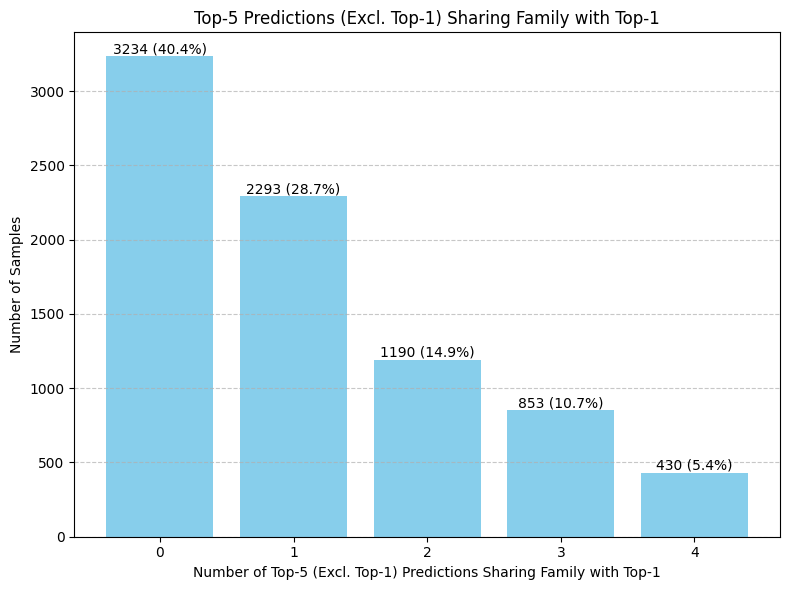

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIGURATION ===
GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

records = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"]}
    edges = data["links"]

    # Build child-to-parent map
    child_to_parent = {}
    for edge in data["links"]:
        child_to_parent[edge["target"]] = edge["source"]

    # Extract top-5 species by confidence
    top5_species_ids = [n["id"] for n in data["nodes"]
                        if n.get("type") == "species" and "confidence" in n and n["confidence"] is not None]
    top5_species_ids = sorted(top5_species_ids, key=lambda sid: -nodes[sid]["confidence"])[:5]

    if len(top5_species_ids) < 1:
        continue

    # Get top-1 family
    top1_species = top5_species_ids[0]
    top1_genus = child_to_parent.get(top1_species)
    top1_family = child_to_parent.get(top1_genus)

    # Count how many of top-5 EXCLUDING top-1 share the same family
    shared_family_count = 0
    for sp in top5_species_ids[1:]:  # exclude top-1
        gen = child_to_parent.get(sp)
        fam = child_to_parent.get(gen)
        if fam == top1_family:
            shared_family_count += 1

    records.append({
        "file": fname,
        "top1_family": top1_family,
        "shared_family_count": shared_family_count
    })

# === Create dataframe and plot ===
df = pd.DataFrame(records)
distribution = df["shared_family_count"].value_counts().sort_index()

# Total samples for normalization
total = distribution.sum()

plt.figure(figsize=(8, 6))
bars = plt.bar(distribution.index, distribution.values, color="skyblue")

# Add count + percentage on top of bars
for bar in bars:
    count = int(bar.get_height())
    percent = 100 * count / total
    label = f"{count} ({percent:.1f}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, count + 20, label, ha='center', fontsize=10)

plt.title("Top-5 Predictions (Excl. Top-1) Sharing Family with Top-1")
plt.xlabel("Number of Top-5 (Excl. Top-1) Predictions Sharing Family with Top-1")
plt.ylabel("Number of Samples")
plt.xticks(range(0, 5))  # Now only 0 to 4 are valid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("figures/Top5_family_shared_With_Top1.png", dpi=300)
plt.show()


### How often does the top-5 share family with the true class?

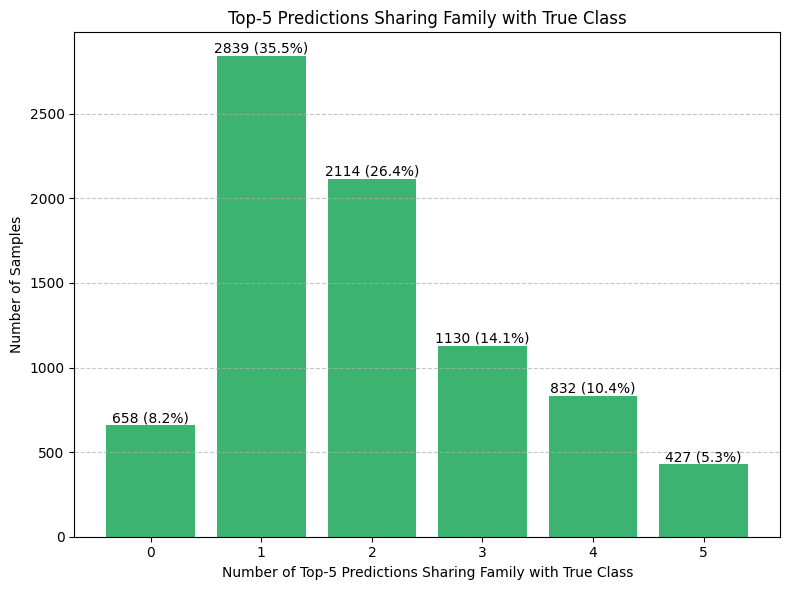

In [45]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIGURATION ===
GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

records = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"]}
    edges = data["links"]

    # Build parent-child map
    child_to_parent = {}
    for edge in edges:
        child_to_parent[edge["target"]] = edge["source"]

    # Step 1: Get top-5 predictions
    top5_species_ids = [n["id"] for n in nodes.values()
                        if n.get("type") == "species" and "confidence" in n and n["confidence"] is not None]
    top5_species_ids = sorted(top5_species_ids, key=lambda sid: -nodes[sid]["confidence"])[:5]

    if not top5_species_ids:
        continue

    # Step 2: Get true species
    true_species = next((n["id"] for n in nodes.values()
                         if n.get("type") == "species" and n.get("is_true", False)), None)
    if not true_species:
        continue

    true_genus = child_to_parent.get(true_species)
    true_family = child_to_parent.get(true_genus)

    # Step 3: Count how many top-5 species share the same family
    shared_family_count = 0
    for sp in top5_species_ids:
        gen = child_to_parent.get(sp)
        fam = child_to_parent.get(gen)
        if fam == true_family:
            shared_family_count += 1

    records.append({
        "file": fname,
        "true_species": true_species,
        "true_family": true_family,
        "shared_family_count": shared_family_count
    })

# === Create DataFrame + Distribution ===
df_true = pd.DataFrame(records)
distribution_true = df_true["shared_family_count"].value_counts().sort_index()
total = distribution_true.sum()

# === Plot ===
plt.figure(figsize=(8, 6))
bars = plt.bar(distribution_true.index, distribution_true.values, color="mediumseagreen")

# Add count + percentage on bars
for bar in bars:
    count = int(bar.get_height())
    percent = 100 * count / total
    label = f"{count} ({percent:.1f}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, count + 20, label, ha='center', fontsize=10)

plt.title("Top-5 Predictions Sharing Family with True Class")
plt.xlabel("Number of Top-5 Predictions Sharing Family with True Class")
plt.ylabel("Number of Samples")
plt.xticks(distribution_true.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("figures/Top5_family_shared_With_True.png", dpi=300)
plt.show()


### Confidence distribution of “Other” Class for Incorrect versus Correct predictions. 

/var/folders/1s/mgxysld95k99xdrvq52v_pp40000gn/T/ipykernel_9901/1218725743.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


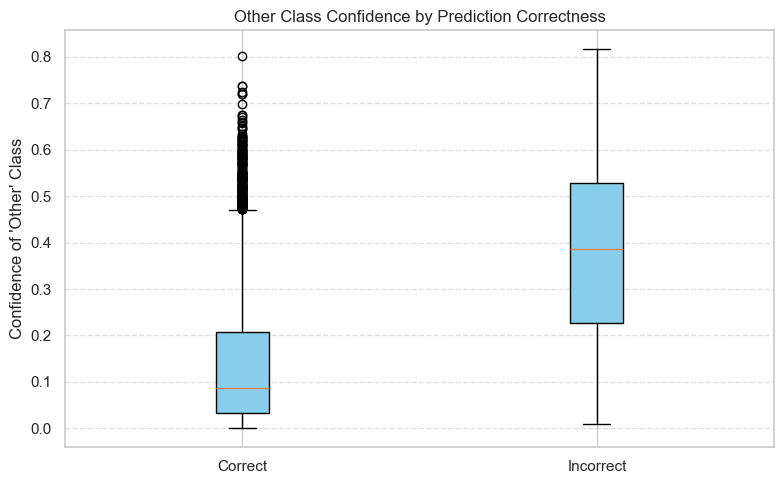

In [64]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

other_confidences = {"correct": [], "incorrect": []}

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    # Collect species nodes with confidence
    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and "confidence" in n and n["confidence"] is not None]

    if not species_nodes:
        continue

    # Get top-1 prediction
    top1 = max(species_nodes, key=lambda n: n["confidence"])
    top1_id = top1["id"]

    # Get true species
    true_species_node = next((n for n in data["nodes"]
                              if n.get("type") == "species" and n.get("is_true", False)), None)
    if not true_species_node:
        continue

    # Get "Other" confidence
    other_node = next((n for n in data["nodes"] if n.get("type") == "other"), None)
    if not other_node or "confidence" not in other_node:
        continue

    correctness = "correct" if top1_id == true_species_node["id"] else "incorrect"
    other_confidences[correctness].append(other_node["confidence"])

# === Plot Boxplot ===
plt.figure(figsize=(8, 5))
plt.boxplot(
    [other_confidences["correct"], other_confidences["incorrect"]],
    labels=["Correct", "Incorrect"],
    patch_artist=True,
    boxprops=dict(facecolor="skyblue"),
)
plt.ylabel("Confidence of 'Other' Class")
plt.title("Other Class Confidence by Prediction Correctness")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/Other_Class_Confidence_by_Prediction_Correctness.png", dpi=300)
plt.show()


### Distribution of the number of unique families in the top-5 predictions

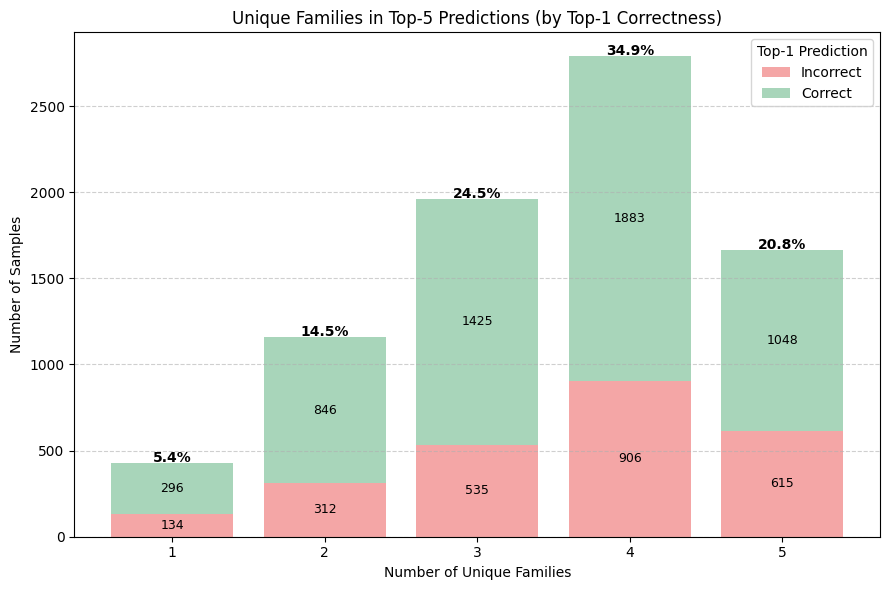

In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

records = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"]}
    edges = data["links"]

    # Build child-to-parent map
    child_to_parent = {edge["target"]: edge["source"] for edge in edges}

    # Get top-5 predicted species (by confidence)
    top5_species = [n["id"] for n in nodes.values()
                    if n.get("type") == "species" and n.get("confidence") is not None]
    top5_species = sorted(top5_species, key=lambda sid: -nodes[sid]["confidence"])[:5]

    if not top5_species:
        continue

    # Get ground-truth species
    true_species = next((n["id"] for n in nodes.values()
                         if n.get("type") == "species" and n.get("is_true")), None)
    if not true_species:
        continue

    # Get top-1 prediction correctness
    is_correct = top5_species[0] == true_species

    # Count unique families in top-5
    families = set()
    for sp in top5_species:
        gen = child_to_parent.get(sp)
        fam = child_to_parent.get(gen)
        if fam:
            families.add(fam)

    records.append({
        "unique_family_count": len(families),
        "correct": is_correct
    })

# === Create DataFrame and Pivot ===
df = pd.DataFrame(records)
pivot_df = df.groupby(["unique_family_count", "correct"]).size().unstack(fill_value=0).sort_index()

# === Plotting ===
plt.figure(figsize=(9, 6))
correct_vals = pivot_df.get(True, pd.Series([0]*len(pivot_df), index=pivot_df.index))
incorrect_vals = pivot_df.get(False, pd.Series([0]*len(pivot_df), index=pivot_df.index))

bars1 = plt.bar(pivot_df.index, incorrect_vals, color="#F4A6A6", label="Incorrect")
bars2 = plt.bar(pivot_df.index, correct_vals, bottom=incorrect_vals, color="#A8D5BA", label="Correct")

# Add counts inside bars
for i, count in enumerate(incorrect_vals):
    if count > 0:
        plt.text(pivot_df.index[i], count / 2, str(count), ha="center", va="center", fontsize=9)

for i, (inc, cor) in enumerate(zip(incorrect_vals, correct_vals)):
    if cor > 0:
        plt.text(pivot_df.index[i], inc + cor / 2, str(cor), ha="center", va="center", fontsize=9)

# Add overall percentage on top
total_samples = correct_vals.sum() + incorrect_vals.sum()
for i, (inc, cor) in enumerate(zip(incorrect_vals, correct_vals)):
    total = inc + cor
    percent = 100 * total / total_samples
    plt.text(pivot_df.index[i], total + 5, f"{percent:.1f}%", ha="center", fontsize=10, fontweight="bold")

plt.title("Unique Families in Top-5 Predictions (by Top-1 Correctness)")
plt.xlabel("Number of Unique Families")
plt.ylabel("Number of Samples")
plt.xticks(pivot_df.index)
plt.legend(title="Top-1 Prediction")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/Unique_Families_in_Top5_Stacked.png", dpi=300)
plt.show()


### Confidence distributions of Top-1, Top-2, Top-3, Top-4, and Top-5 predictions



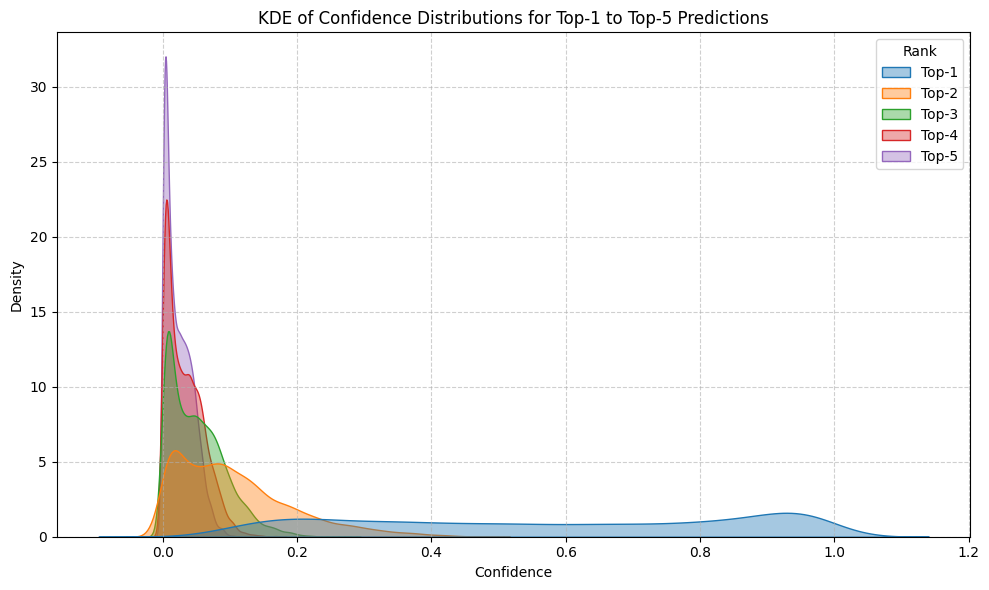

In [47]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load graphs ===
GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

# Collect confidences for top-1 through top-5
topk_confidences = {k: [] for k in range(1, 6)}

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    # Get species nodes with confidence
    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 5:
        continue

    sorted_nodes = sorted(species_nodes, key=lambda n: -n["confidence"])[:5]

    for i, node in enumerate(sorted_nodes):
        topk_confidences[i + 1].append(node["confidence"])

# === Prepare DataFrame for KDE ===
plot_data = []
for k in range(1, 6):
    for conf in topk_confidences[k]:
        plot_data.append({"Rank": f"Top-{k}", "Confidence": conf})

df_kde = pd.DataFrame(plot_data)

# === KDE Plot ===
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_kde, x="Confidence", hue="Rank", fill=True, common_norm=False, alpha=0.4)
plt.title("KDE of Confidence Distributions for Top-1 to Top-5 Predictions")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/KDE_of_Confidence_Distributions_Top1_to_Top5_Predictions.png", dpi=300)
plt.show()


### 5 separate KDE plots, each showing the confidence distribution of Top-k predictions (k=1 to 5) split by: (1) Correct predictions (top-1 == true species) and (2) Incorrect predictions (top-1 ≠ true species)

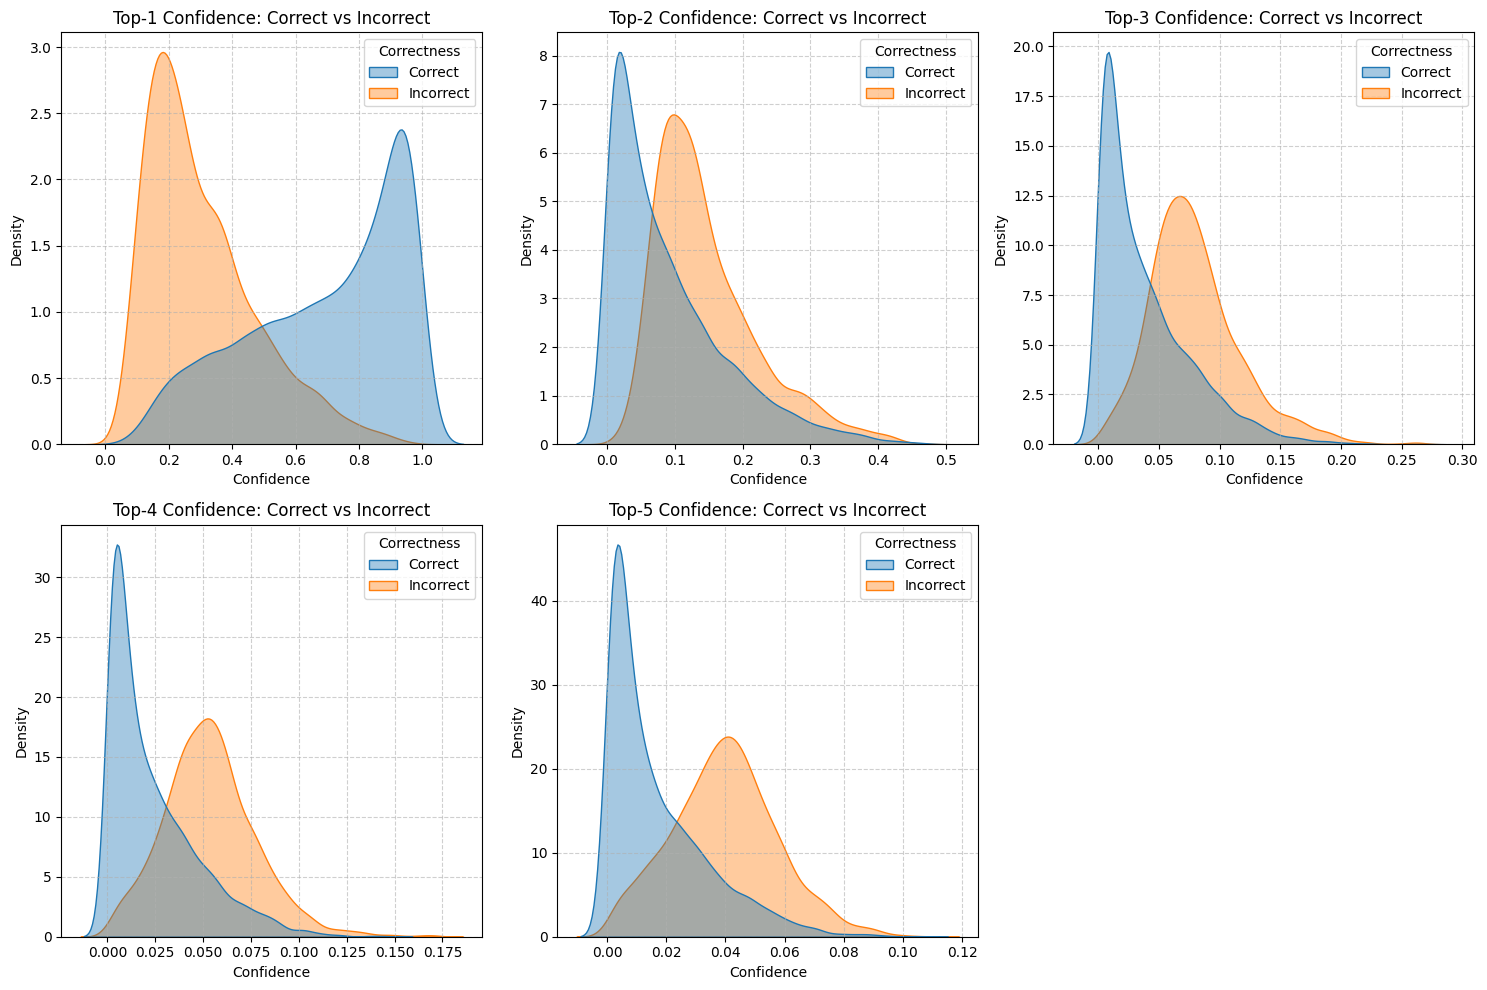

In [48]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

# Collect top-k confidence distributions by correctness
topk_correctness_conf = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    # Get species nodes with confidence
    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 5:
        continue

    sorted_species = sorted(species_nodes, key=lambda n: -n["confidence"])[:5]
    top1 = sorted_species[0]

    true_species = next((n for n in data["nodes"]
                         if n.get("type") == "species" and n.get("is_true", False)), None)

    if not true_species:
        continue

    correctness = "Correct" if top1["id"] == true_species["id"] else "Incorrect"

    for i, node in enumerate(sorted_species):
        topk_correctness_conf.append({
            "Rank": f"Top-{i+1}",
            "Confidence": node["confidence"],
            "Correctness": correctness
        })

# Convert to DataFrame
df_conf_split = pd.DataFrame(topk_correctness_conf)

# === Plot 5 KDEs ===
plt.figure(figsize=(15, 10))
for i, rank in enumerate([f"Top-{k}" for k in range(1, 6)], start=1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df_conf_split[df_conf_split["Rank"] == rank],
                x="Confidence", hue="Correctness", fill=True, common_norm=False, alpha=0.4)
    plt.title(f"{rank} Confidence: Correct vs Incorrect")
    plt.xlabel("Confidence")
    plt.ylabel("Density")
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("figures/KDE_of_Confidence_Distributions_T1to5_Correct_Incorrect.png", dpi=300)
plt.show()


### Number of correct vs incorrect predictions per Top-k rank

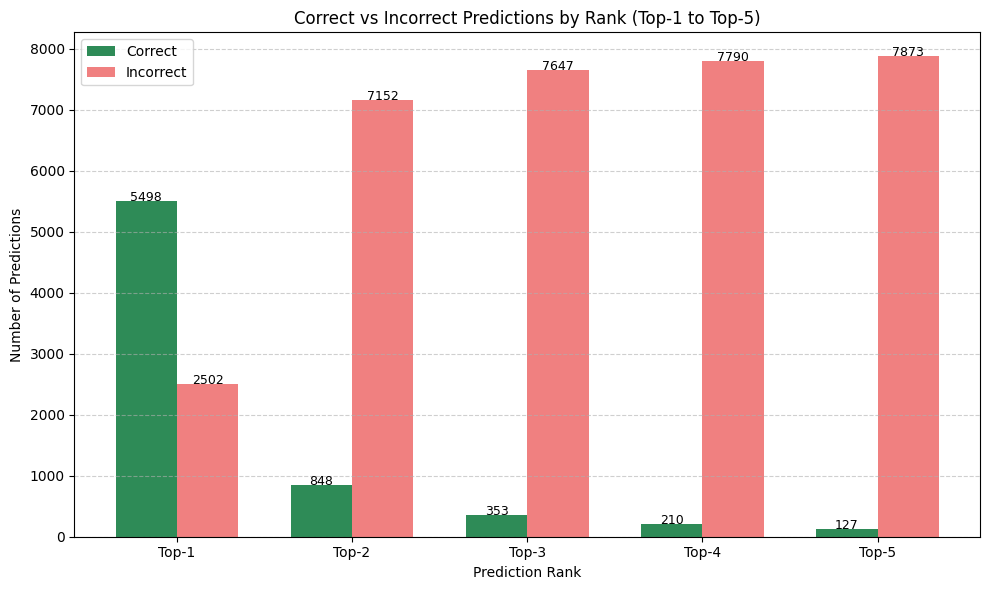

In [49]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

# Count correct/incorrect by rank
match_counts = {k: {"correct": 0, "incorrect": 0} for k in range(1, 6)}

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 5:
        continue

    sorted_species = sorted(species_nodes, key=lambda n: -n["confidence"])[:5]

    true_species = next((n for n in data["nodes"]
                         if n.get("type") == "species" and n.get("is_true", False)), None)
    if not true_species:
        continue

    true_id = true_species["id"]

    for k, node in enumerate(sorted_species, start=1):
        if node["id"] == true_id:
            match_counts[k]["correct"] += 1
        else:
            match_counts[k]["incorrect"] += 1

# Prepare for plotting
ranks = [f"Top-{k}" for k in range(1, 6)]
correct_vals = [match_counts[k]["correct"] for k in range(1, 6)]
incorrect_vals = [match_counts[k]["incorrect"] for k in range(1, 6)]

x = range(len(ranks))
bar_width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], correct_vals, width=bar_width, label="Correct", color="seagreen")
plt.bar([i + bar_width/2 for i in x], incorrect_vals, width=bar_width, label="Incorrect", color="lightcoral")

# Add annotations
for i in x:
    plt.text(i - bar_width/2, correct_vals[i] + 5, str(correct_vals[i]), ha='center', fontsize=9)
    plt.text(i + bar_width/2, incorrect_vals[i] + 5, str(incorrect_vals[i]), ha='center', fontsize=9)

plt.title("Correct vs Incorrect Predictions by Rank (Top-1 to Top-5)")
plt.xlabel("Prediction Rank")
plt.ylabel("Number of Predictions")
plt.xticks(x, ranks)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/Correct_vs_Incorrect_Predictions_by_Rank.png", dpi=300)
plt.show()


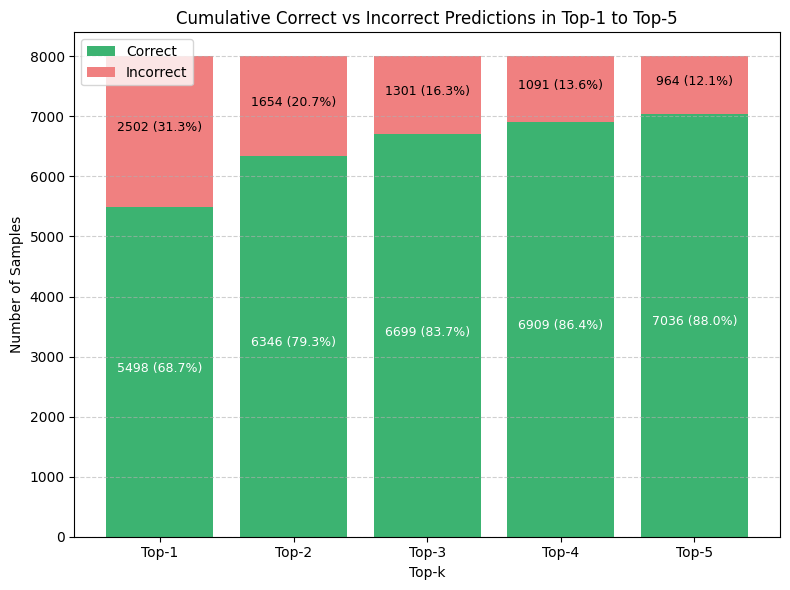

In [50]:
import os
import json
import matplotlib.pyplot as plt

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

correct_counts = {k: 0 for k in range(1, 6)}
total_samples = 0

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 5:
        continue

    sorted_species = sorted(species_nodes, key=lambda n: -n["confidence"])[:5]

    true_species = next((n for n in data["nodes"]
                         if n.get("type") == "species" and n.get("is_true", False)), None)
    if not true_species:
        continue

    total_samples += 1
    true_id = true_species["id"]

    found_rank = None
    for i, node in enumerate(sorted_species):
        if node["id"] == true_id:
            found_rank = i + 1
            break

    for k in range(1, 6):
        if found_rank and found_rank <= k:
            correct_counts[k] += 1

# Prepare data
ranks = [f"Top-{k}" for k in range(1, 6)]
correct_vals = [correct_counts[k] for k in range(1, 6)]
incorrect_vals = [total_samples - correct_counts[k] for k in range(1, 6)]

# Plot stacked bars
plt.figure(figsize=(8, 6))
bars1 = plt.bar(ranks, correct_vals, label="Correct", color="mediumseagreen")
bars2 = plt.bar(ranks, incorrect_vals, bottom=correct_vals, label="Incorrect", color="lightcoral")

# Add count + % on bars
for i in range(5):
    total = correct_vals[i] + incorrect_vals[i]
    correct_pct = 100 * correct_vals[i] / total
    incorrect_pct = 100 * incorrect_vals[i] / total

    plt.text(i, correct_vals[i] / 2, f"{correct_vals[i]} ({correct_pct:.1f}%)", ha='center', color='white', fontsize=9)
    plt.text(i, correct_vals[i] + incorrect_vals[i] / 2, f"{incorrect_vals[i]} ({incorrect_pct:.1f}%)", ha='center', color='black', fontsize=9)

plt.title("Cumulative Correct vs Incorrect Predictions in Top-1 to Top-5")
plt.xlabel("Top-k")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/Correct_vs_Incorrect_Predictions_by_Rank_Cumulative.png", dpi=300)
plt.show()


### Depth distribution of the Top-1 predicted species in the taxonomy tree

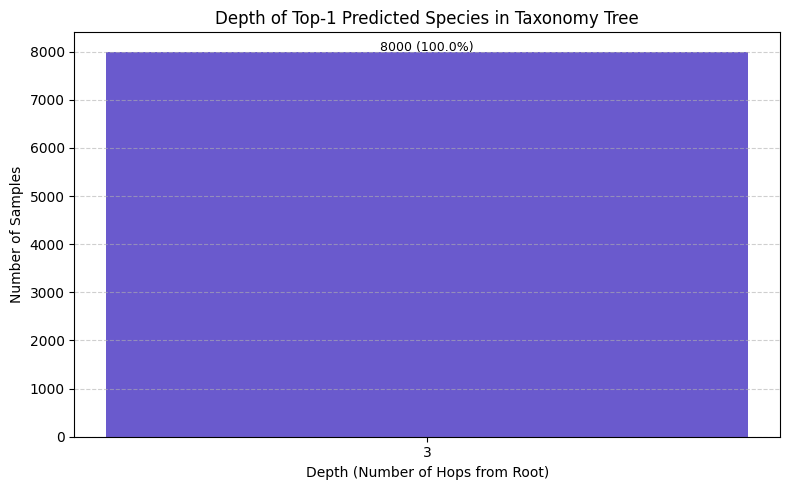

In [30]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

depths = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"] if "type" in n}
    reverse_map = defaultdict(list)
    for edge in data["links"]:
        reverse_map[edge["target"]].append(edge["source"])

    # Find top-1 species
    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]
    if not species_nodes:
        continue

    top1_node = max(species_nodes, key=lambda n: n["confidence"])
    top1_id = top1_node["id"]

    # Traverse upward to root
    visited = set()
    current = top1_id
    depth = 0
    while current in reverse_map:
        parent = reverse_map[current][0]  # pick first if multiple
        if parent in visited:
            break  # prevent cycle
        visited.add(parent)
        current = parent
        depth += 1

        if current == "Aves":
            break

    depths.append(depth)

# === Plot ===
from collections import Counter

depth_counts = Counter(depths)
sorted_depths = sorted(depth_counts.items())

labels = [str(d) for d, _ in sorted_depths]
values = [c for _, c in sorted_depths]
total = sum(values)

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color="slateblue")

# Annotate with count + %
for i, bar in enumerate(bars):
    count = bar.get_height()
    percent = 100 * count / total
    plt.text(bar.get_x() + bar.get_width() / 2, count + 2, f"{count} ({percent:.1f}%)", ha='center', fontsize=9)

plt.title("Depth of Top-1 Predicted Species in Taxonomy Tree")
plt.xlabel("Depth (Number of Hops from Root)")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Depth difference between Top-1 predicted species and the True species

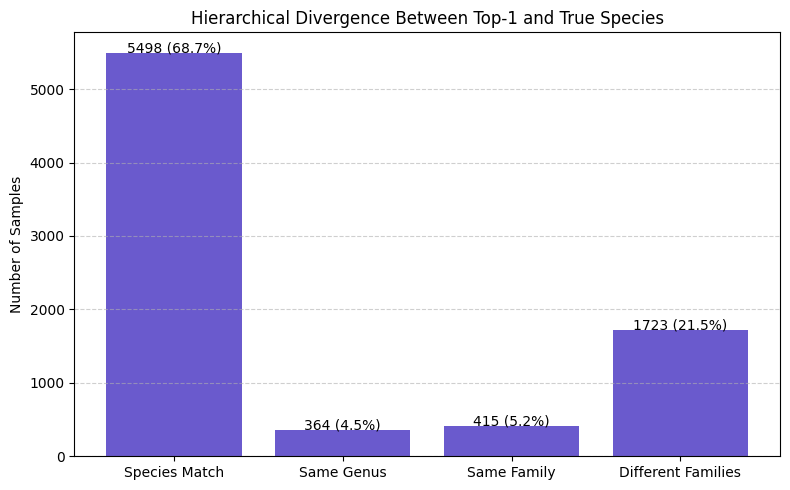

In [51]:
import os
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

divergence_levels = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"]}
    edges = data["links"]

    # Build reverse tree (child → parent)
    child_to_parent = {}
    for edge in edges:
        child_to_parent[edge["target"]] = edge["source"]

    # Get top-1 species
    species_nodes = [n for n in nodes.values() if n.get("type") == "species" and n.get("confidence") is not None]
    if not species_nodes:
        continue
    top1 = max(species_nodes, key=lambda n: n["confidence"])["id"]

    # Get true species
    true = next((n["id"] for n in nodes.values() if n.get("type") == "species" and n.get("is_true")), None)
    if not true:
        continue

    # Walk paths upward: species → genus → family → Aves
    def get_path_to_root(node_id):
        path = []
        current = node_id
        while current in child_to_parent:
            parent = child_to_parent[current]
            path.append(parent)
            current = parent
            if parent == "Aves":
                break
        return path

    path_top1 = get_path_to_root(top1)
    path_true = get_path_to_root(true)

    # Normalize to [family, genus, species]
    def extract_lineage(path):
        fam = next((n for n in path if nodes.get(n, {}).get("type") == "family"), None)
        gen = next((n for n in path if nodes.get(n, {}).get("type") == "genus"), None)
        return fam, gen

    fam_top1, gen_top1 = extract_lineage(path_top1)
    fam_true, gen_true = extract_lineage(path_true)

    if top1 == true:
        level = 0  # exact species match
    elif gen_top1 == gen_true:
        level = 1  # same genus
    elif fam_top1 == fam_true:
        level = 2  # same family
    else:
        level = 3  # different families

    divergence_levels.append(level)

# === Count and plot ===
level_labels = {
    0: "Species Match",
    1: "Same Genus",
    2: "Same Family",
    3: "Different Families"
}
counts = Counter(divergence_levels)
sorted_items = sorted(counts.items())
labels = [level_labels[lvl] for lvl, _ in sorted_items]
values = [counts[lvl] for lvl, _ in sorted_items]
total = sum(values)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color="slateblue")

for i, bar in enumerate(bars):
    count = bar.get_height()
    pct = 100 * count / total
    plt.text(bar.get_x() + bar.get_width()/2, count + 5, f"{count} ({pct:.1f}%)", ha='center', fontsize=10)

plt.title("Hierarchical Divergence Between Top-1 and True Species")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("figures/Hierarchical_Divergence_Between_Top1_and_True_Species.png", dpi=300)
plt.show()


### Distribution of species level confidence margin (Difference between top-1 and top-2)

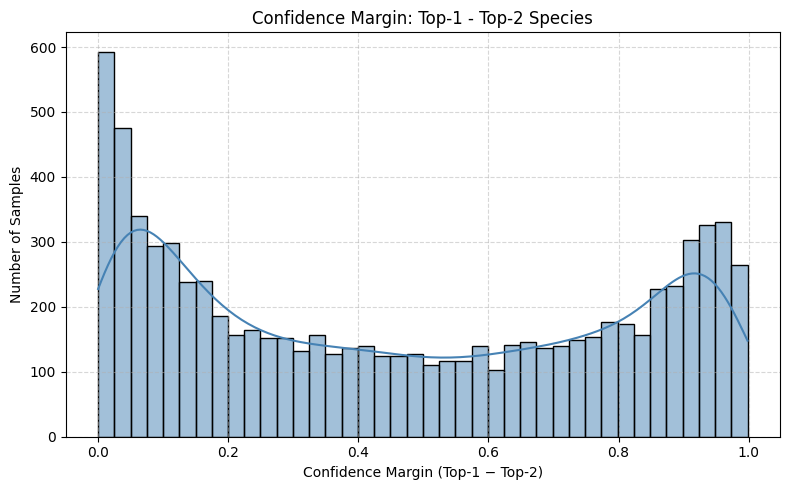

Number of samples: 8000
Mean margin     : 0.4621
Median margin   : 0.4273
Std deviation   : 0.3392
Min margin      : 0.0001
Max margin      : 0.9982


In [53]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

margins = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 2:
        continue

    sorted_nodes = sorted(species_nodes, key=lambda x: -x["confidence"])
    conf1 = sorted_nodes[0]["confidence"]
    conf2 = sorted_nodes[1]["confidence"]
    margins.append(conf1 - conf2)

# === Plot distribution ===
plt.figure(figsize=(8, 5))
sns.histplot(margins, bins=40, kde=True, color="steelblue")
plt.title("Confidence Margin: Top-1 - Top-2 Species")
plt.xlabel("Confidence Margin (Top-1 − Top-2)")
plt.ylabel("Number of Samples")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("figures/Top1-Top2_Conf.png", dpi=300)
plt.show()

# === Print summary stats ===
print(f"Number of samples: {len(margins)}")
print(f"Mean margin     : {np.mean(margins):.4f}")
print(f"Median margin   : {np.median(margins):.4f}")
print(f"Std deviation   : {np.std(margins):.4f}")
print(f"Min margin      : {np.min(margins):.4f}")
print(f"Max margin      : {np.max(margins):.4f}")


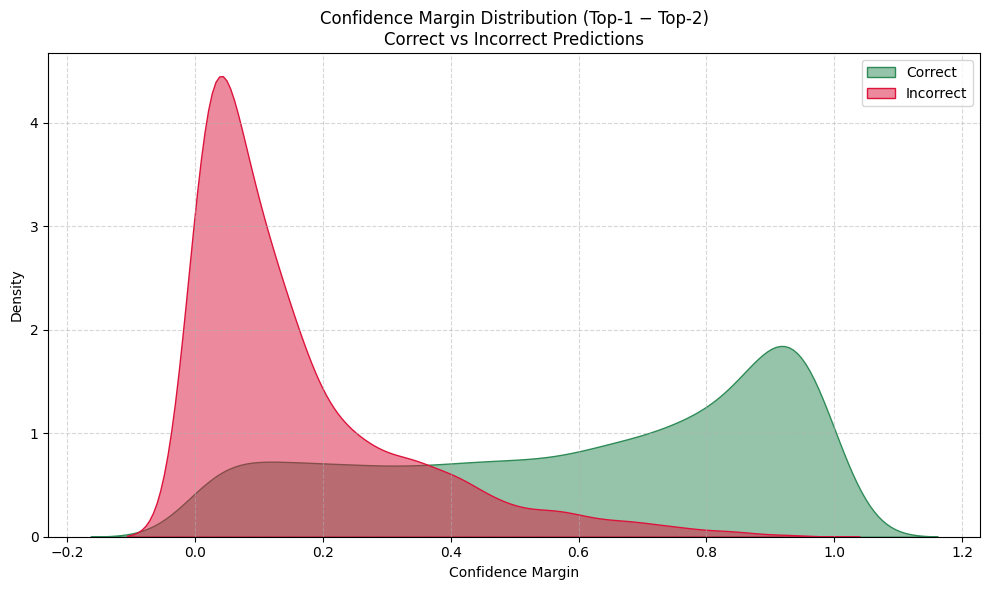


Correct Predictions:
Count     : 5498
Mean      : 0.6003
Median    : 0.6671
Std Dev   : 0.3054
Min       : 0.0001
Max       : 0.9982

Incorrect Predictions:
Count     : 2502
Mean      : 0.1584
Median    : 0.0985
Std Dev   : 0.1695
Min       : 0.0001
Max       : 0.9338


In [52]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

correct_margins = []
incorrect_margins = []

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 2:
        continue

    sorted_nodes = sorted(species_nodes, key=lambda x: -x["confidence"])
    conf1 = sorted_nodes[0]["confidence"]
    conf2 = sorted_nodes[1]["confidence"]
    margin = conf1 - conf2

    top1_id = sorted_nodes[0]["id"]
    top1_is_true = sorted_nodes[0].get("is_true", False)

    if top1_is_true:
        correct_margins.append(margin)
    else:
        incorrect_margins.append(margin)

# === Plot KDE overlay ===
plt.figure(figsize=(10, 6))
sns.kdeplot(correct_margins, label="Correct", fill=True, alpha=0.5, color='seagreen')
sns.kdeplot(incorrect_margins, label="Incorrect", fill=True, alpha=0.5, color='crimson')
plt.title("Confidence Margin Distribution (Top-1 − Top-2)\nCorrect vs Incorrect Predictions")
plt.xlabel("Confidence Margin")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("figures/Top1-Top2_Conf_Diff_Corr_InCorr.png", dpi=300)
plt.show()

# === Stats ===
def print_stats(label, values):
    print(f"\n{label} Predictions:")
    print(f"Count     : {len(values)}")
    print(f"Mean      : {np.mean(values):.4f}")
    print(f"Median    : {np.median(values):.4f}")
    print(f"Std Dev   : {np.std(values):.4f}")
    print(f"Min       : {np.min(values):.4f}")
    print(f"Max       : {np.max(values):.4f}")

print_stats("Correct", correct_margins)
print_stats("Incorrect", incorrect_margins)


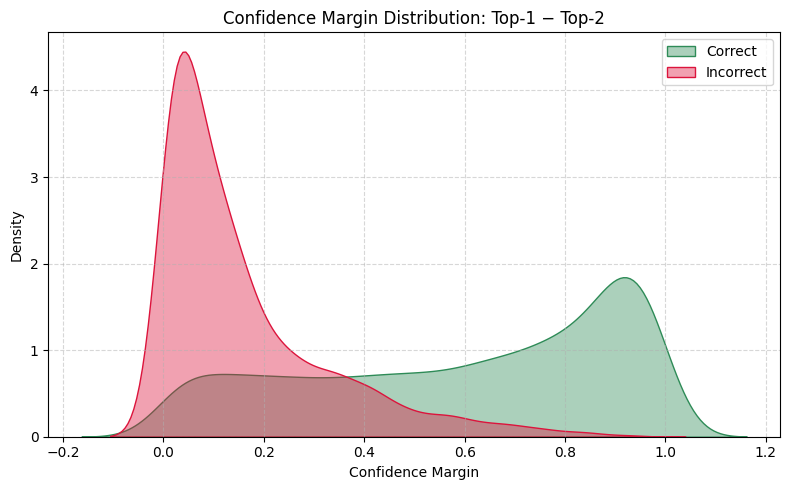


Top-1 − Top-2 (Correct)
  Count : 5498
  Mean  : 0.6003
  Median: 0.6671
  Std   : 0.3054
  Min   : 0.0001
  Max   : 0.9982

Top-1 − Top-2 (Incorrect)
  Count : 2502
  Mean  : 0.1584
  Median: 0.0985
  Std   : 0.1695
  Min   : 0.0001
  Max   : 0.9338


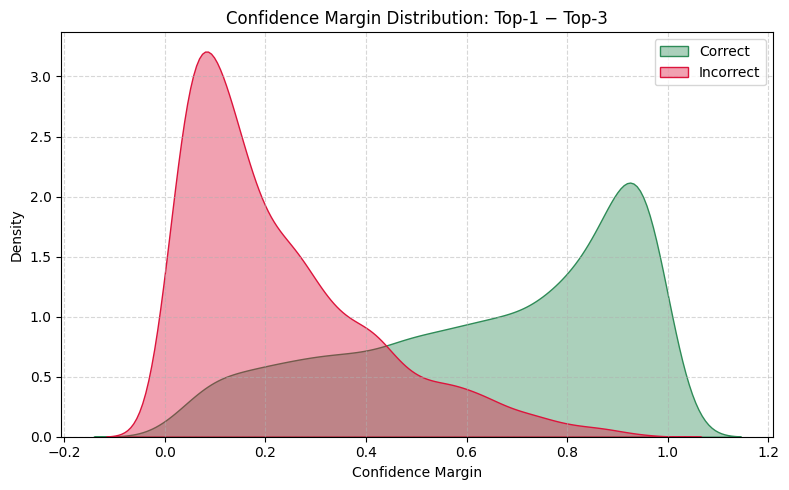


Top-1 − Top-3 (Correct)
  Count : 5498
  Mean  : 0.6513
  Median: 0.7168
  Std   : 0.2738
  Min   : 0.0054
  Max   : 0.9983

Top-1 − Top-3 (Incorrect)
  Count : 2502
  Mean  : 0.2257
  Median: 0.1657
  Std   : 0.1865
  Min   : 0.0011
  Max   : 0.9494


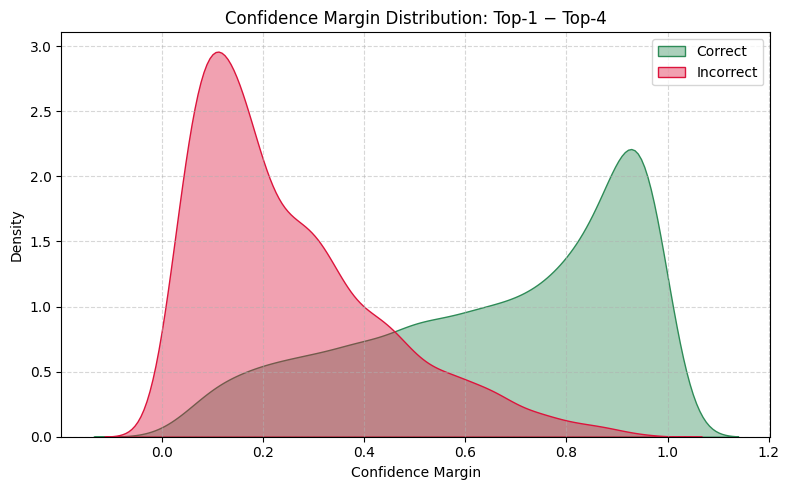


Top-1 − Top-4 (Correct)
  Count : 5498
  Mean  : 0.6659
  Median: 0.7293
  Std   : 0.2632
  Min   : 0.0065
  Max   : 0.9984

Top-1 − Top-4 (Incorrect)
  Count : 2502
  Mean  : 0.2516
  Median: 0.1969
  Std   : 0.1859
  Min   : 0.0037
  Max   : 0.9512


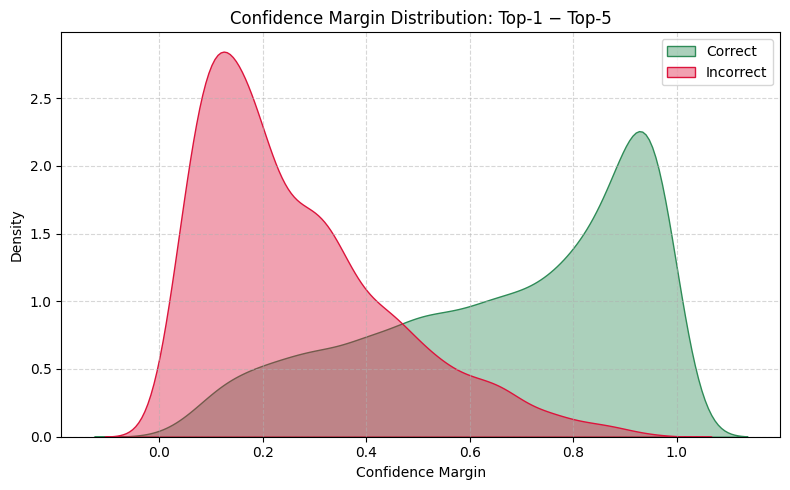


Top-1 − Top-5 (Correct)
  Count : 5498
  Mean  : 0.6727
  Median: 0.7354
  Std   : 0.2580
  Min   : 0.0121
  Max   : 0.9984

Top-1 − Top-5 (Incorrect)
  Count : 2502
  Mean  : 0.2653
  Median: 0.2155
  Std   : 0.1846
  Min   : 0.0105
  Max   : 0.9516


In [54]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

correct_margins = {2: [], 3: [], 4: [], 5: []}
incorrect_margins = {2: [], 3: [], 4: [], 5: []}

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    species_nodes = [n for n in data["nodes"]
                     if n.get("type") == "species" and n.get("confidence") is not None]

    if len(species_nodes) < 5:
        continue

    sorted_nodes = sorted(species_nodes, key=lambda x: -x["confidence"])
    confs = [n["confidence"] for n in sorted_nodes[:5]]
    top1_is_true = sorted_nodes[0].get("is_true", False)

    for k in range(2, 6):
        margin = confs[0] - confs[k - 1]
        if top1_is_true:
            correct_margins[k].append(margin)
        else:
            incorrect_margins[k].append(margin)

# === Function to print stats ===
def print_stats(title, values):
    print(f"\n{title}")
    print(f"  Count : {len(values)}")
    print(f"  Mean  : {np.mean(values):.4f}")
    print(f"  Median: {np.median(values):.4f}")
    print(f"  Std   : {np.std(values):.4f}")
    print(f"  Min   : {np.min(values):.4f}")
    print(f"  Max   : {np.max(values):.4f}")

# === Plot and print for each k ===
for k in range(2, 6):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(correct_margins[k], label="Correct", fill=True, alpha=0.4, color='seagreen')
    sns.kdeplot(incorrect_margins[k], label="Incorrect", fill=True, alpha=0.4, color='crimson')
    plt.title(f"Confidence Margin Distribution: Top-1 − Top-{k}")
    plt.xlabel("Confidence Margin")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/Top1-Top{k}_Conf_Diff_Corr_InCorr.png", dpi=300)
    plt.show()

    # Print stats
    print_stats(f"Top-1 − Top-{k} (Correct)", correct_margins[k])
    print_stats(f"Top-1 − Top-{k} (Incorrect)", incorrect_margins[k])


### Top-1 model confidence distributions grouped by hierarchical relationship between the top-1 prediction and the true species.

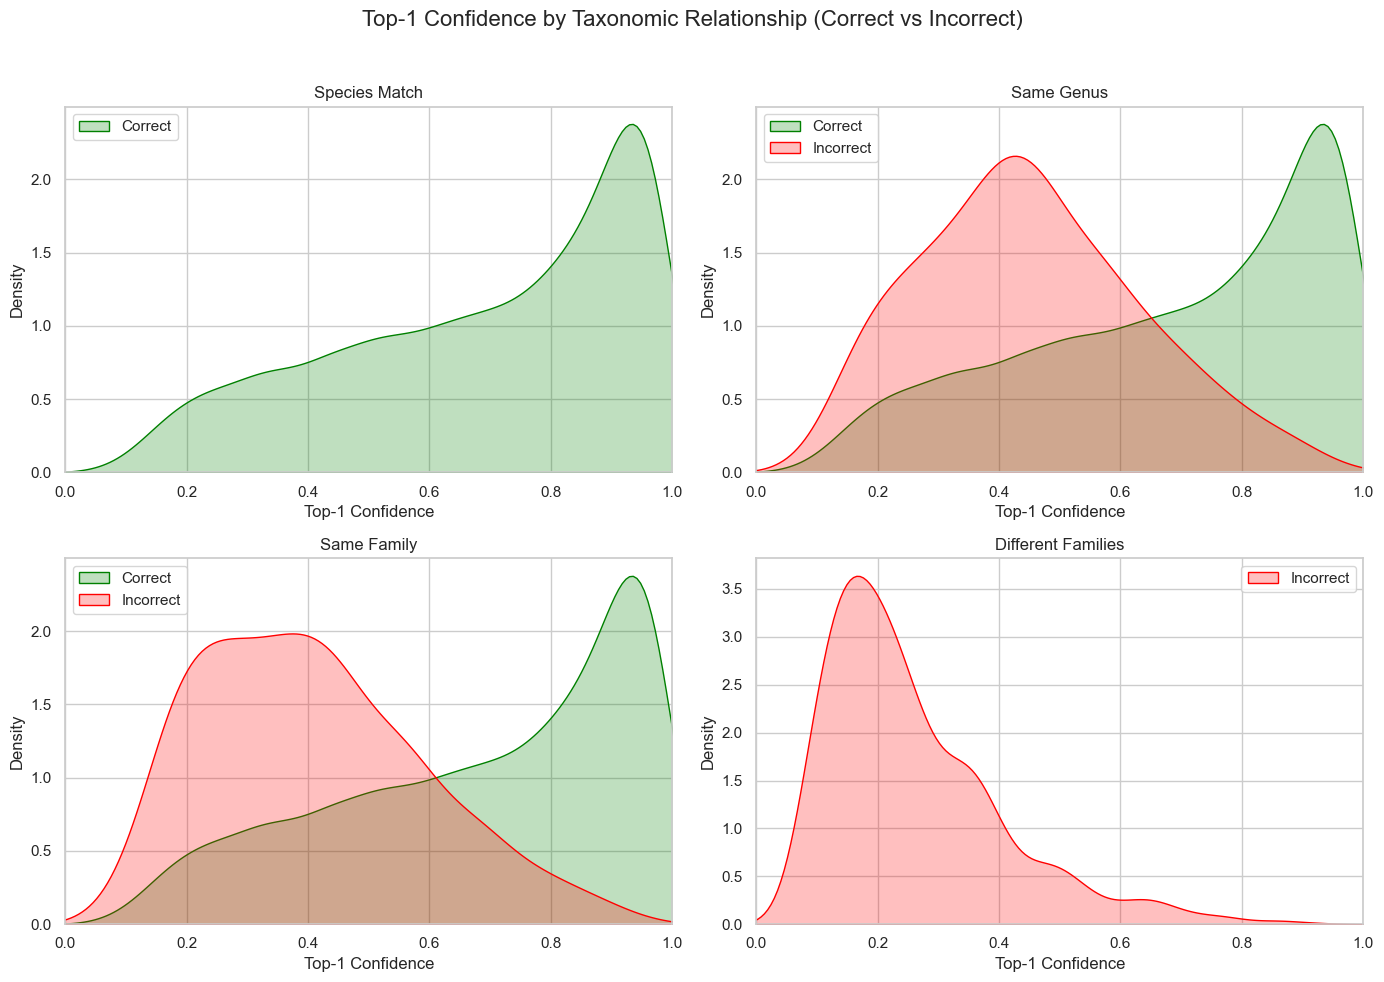

In [63]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

GRAPH_DIR = "taxonomy_graphs_json"
graph_files = sorted([f for f in os.listdir(GRAPH_DIR) if f.endswith(".json")])

# Initialize
confidence_by_group = {
    "Species Match": {"correct": [], "incorrect": []},
    "Same Genus": {"correct": [], "incorrect": []},
    "Same Family": {"correct": [], "incorrect": []},
    "Different Families": {"correct": [], "incorrect": []},
}

for fname in graph_files:
    with open(os.path.join(GRAPH_DIR, fname)) as f:
        data = json.load(f)

    nodes = {n["id"]: n for n in data["nodes"]}
    edges = data["links"]
    child_to_parent = {edge["target"]: edge["source"] for edge in edges}

    # Get species nodes
    species_nodes = [n for n in nodes.values() if n.get("type") == "species" and n.get("confidence") is not None]
    if not species_nodes:
        continue
    top1_node = max(species_nodes, key=lambda n: n["confidence"])
    top1_id = top1_node["id"]
    top1_conf = top1_node["confidence"]

    true_node = next((n for n in nodes.values() if n.get("type") == "species" and n.get("is_true")), None)
    if not true_node:
        continue
    true_id = true_node["id"]

    def get_lineage(node_id):
        lineage = {"genus": None, "family": None}
        current = node_id
        while current in child_to_parent:
            parent = child_to_parent[current]
            node = nodes.get(parent, {})
            if node.get("type") == "genus" and lineage["genus"] is None:
                lineage["genus"] = parent
            if node.get("type") == "family" and lineage["family"] is None:
                lineage["family"] = parent
            if parent == "Aves":
                break
            current = parent
        return lineage

    lineage_top1 = get_lineage(top1_id)
    lineage_true = get_lineage(true_id)
    is_correct = top1_id == true_id

    # Species match (only correct)
    if top1_id == true_id:
        confidence_by_group["Species Match"]["correct"].append(top1_conf)

    # Same genus
    if lineage_top1["genus"] == lineage_true["genus"]:
        key = "correct" if is_correct else "incorrect"
        confidence_by_group["Same Genus"][key].append(top1_conf)

    # Same family
    if lineage_top1["family"] == lineage_true["family"]:
        key = "correct" if is_correct else "incorrect"
        confidence_by_group["Same Family"][key].append(top1_conf)

    # Different family (only incorrect)
    if lineage_top1["family"] != lineage_true["family"]:
        confidence_by_group["Different Families"]["incorrect"].append(top1_conf)

# === Plot ===
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
group_names = ["Species Match", "Same Genus", "Same Family", "Different Families"]
axes = axes.flatten()

for ax, group in zip(axes, group_names):
    data = confidence_by_group[group]
    if data["correct"]:
        sns.kdeplot(data["correct"], label="Correct", fill=True, ax=ax, color="green")
    if data["incorrect"]:
        sns.kdeplot(data["incorrect"], label="Incorrect", fill=True, ax=ax, color="red")
    ax.set_title(group)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Top-1 Confidence")
    ax.set_ylabel("Density")
    ax.legend()

plt.suptitle("Top-1 Confidence by Taxonomic Relationship (Correct vs Incorrect)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figures/Hierarchical_Divergence_Conf.png", dpi=300)
plt.show()
